# Лабораторна робота №4: Структури для роботи з великими обсягами даних в Python
### *виконала студентка групи ФБ-33 Журавльова Марія*

## Другий рівень (ускладнений)

Професійний Data scientist має вміти працювати з різнотипними датасетами, обробляти їх, візуалізувати та знаходити закономірності. Тому першим кроком є вибір датасету. Пропонуємо для подальших робіт вибрати датасет, що вам сподобається, наприклад із архіву https://archive.ics.uci.edu/datasets.
Датасет має відповідати таким вимогам:
- Data Set Characteristics: Multivariate
- Attribute Characteristics: Categorical, Integer, Real
- Number of Attributes: at least 2 integers/real
- Missing Values? YES!

Я обрала датасет Automobile (https://archive.ics.uci.edu/dataset/10/automobile)

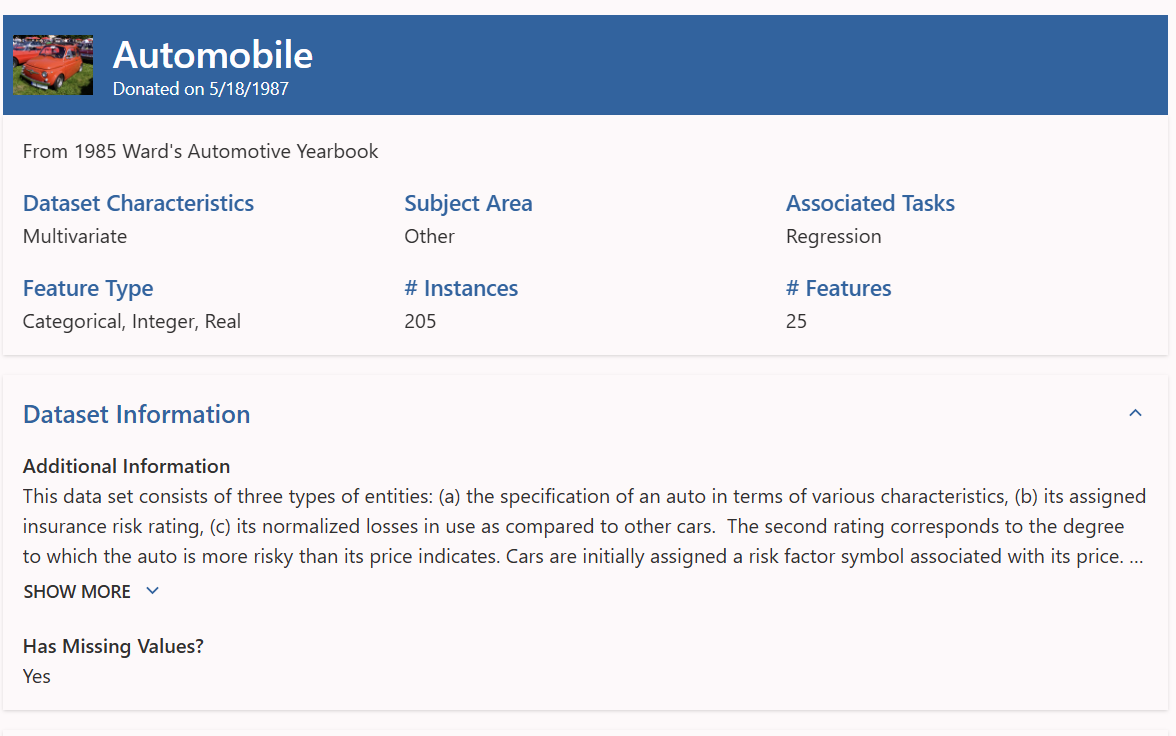

In [67]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
from tabulate import tabulate
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D
print("Setup Complete!")

Setup Complete!


In [2]:
def clean_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Директорія {directory} створена.")
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            shutil.rmtree(filepath)
        elif os.path.exists(filepath):
            os.unlink(filepath)
    print("Директорія очищена.")
    
def download_csv(directory):
    url = "https://archive.ics.uci.edu/static/public/10/automobile.zip"
    
    filename = 'automobile.zip'
    filepath = os.path.join(directory, filename)
    if os.path.exists(filepath):
        print(f"Файл {filename} вже існує. Завантаження не потрібно.")
        return
    
    try:
        with urllib.request.urlopen(url) as wp:
            file_content = wp.read()
        
        with open(filepath, 'wb') as out_file:
            out_file.write(file_content)
        print(f"Файл {filename} завантажено успішно.")
    except urllib.error.URLError as e:
        print(f"Помилка завантаження файлу {filename}: {e}")

def unzip(directory):
    zip_file = os.path.join(directory, "automobile.zip")
    
    if not os.path.exists(zip_file):
        print("Zip-файл не знайдено.")
        return
    
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(path=directory)
            print(f"Файли успішно розархівовано.")
            for filename in zip_ref.namelist():
                if filename.endswith('.data'):
                    new_filename = 'auto.csv'
                    os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
                    print(f"Файл {filename} перейменовано на: {new_filename}")
    except zipfile.BadZipFile as e:
        print(f"Помилка розпакування: {e}")

directory = r"C:/Users/User/vhi_venv/data_lab4_2"
clean_directory(directory)
download_csv(directory)
unzip(directory)

Директорія очищена.
Файл automobile.zip завантажено успішно.
Файли успішно розархівовано.
Файл automobile/imports-85.data перейменовано на: auto.csv


Виконати всі завдання, використовуючи як numpy array, так і dataframe
1. Поборотися із зниклими даними. Для цього подивитись https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/

In [3]:
# Pandas
def load_data_pd(csv_file_path):
    headers = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration",
               "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base",
               "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders", 
               "engine-size", "fuel-system", "bore", "stroke", "compression_ratio",
               "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]
    try:
        df = pd.read_csv(csv_file_path, names=headers, na_values='?', delimiter=',')
        print(f"Дані завантажено успішно в DataFrame.")
        return df
    except Exception as e:
        print(f"Помилка при завантаженні даних: {e}")
        return None

def print_table_pd(df):
    table_data = df.head(10).values.tolist()
    headers = df.columns.tolist()
    print("Перші 10 рядків DataFrame:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))

csv_file = r"C:/Users/User/vhi_venv/data_lab4_2/auto.csv"
df = load_data_pd(csv_file)
if df is not None:
    print("\nЗагальна інформація про датафрейм:")
    print(df.info())
    print(df.isnull().sum())
    print_table_pd(df)

Дані завантажено успішно в DataFrame.

Загальна інформація про датафрейм:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  

In [4]:
# Numpy
def load_data_np(csv_file_path):
    types = [
        ('symboling', 'i4'),  # int64
        ('normalized_losses', 'f8'),  # float64
        ('make', 'U50'),  # object
        ('fuel_type', 'U50'),  # object
        ('aspiration', 'U50'),  # object
        ('num_of_doors', 'U50'),  # object
        ('body_style', 'U50'),  # object
        ('drive_wheels', 'U50'),  # object
        ('engine_location', 'U50'),  # object
        ('wheel_base', 'f8'),  # float64
        ('length', 'f8'),  # float64
        ('width', 'f8'),  # float64
        ('height', 'f8'),  # float64
        ('curb_weight', 'i4'),  # int64
        ('engine_type', 'U50'),  # object
        ('num_of_cylinders', 'U50'),  # object
        ('engine_size', 'i4'),  # int64
        ('fuel_system', 'U50'),  # object
        ('bore', 'f8'),  # float64
        ('stroke', 'f8'),  # float64
        ('compression_ratio', 'f8'),  # float64
        ('horsepower', 'f8'),  # float64
        ('peak_rpm', 'f8'),  # float64
        ('city_mpg', 'i4'),  # int64
        ('highway_mpg', 'i4'),  # int64
        ('price', 'f8')  # float64
    ]
    
    try:
        df_np = np.genfromtxt(csv_file_path, delimiter=',', dtype=types,  filling_values=np.nan, encoding="utf-8")
        print("Дані завантажено успішно у numpy масив.")
        return df_np
    except Exception as e:
        print(f"Помилка при завантаженні даних: {e}")
        return None

def check_missing_values_np(df_np):
    for column in df_np.dtype.names:
        if np.issubdtype(df_np[column].dtype, np.floating):
            missing = np.sum(np.isnan(df_np[column]))
        else:
            missing = np.sum(df_np[column] == "?")
        print(f"{column}: {missing}")

def print_table_np(data):
    table_data = data[:10].tolist()
    print("Перші 10 рядків NumPy масиву:")
    print(tabulate(table_data, tablefmt='pretty'))

csv_file = r"C:/Users/User/vhi_venv/data_lab4_2/auto.csv"
df_np = load_data_np(csv_file)
if df_np is not None:
    check_missing_values_np(df_np)
    print_table_np(df_np)

Дані завантажено успішно у numpy масив.
symboling: 0
normalized_losses: 41
make: 0
fuel_type: 0
aspiration: 0
num_of_doors: 2
body_style: 0
drive_wheels: 0
engine_location: 0
wheel_base: 0
length: 0
width: 0
height: 0
curb_weight: 0
engine_type: 0
num_of_cylinders: 0
engine_size: 0
fuel_system: 0
bore: 4
stroke: 4
compression_ratio: 0
horsepower: 2
peak_rpm: 2
city_mpg: 0
highway_mpg: 0
price: 4
Перші 10 рядків NumPy масиву:
+---+-------+-------------+-----+-------+------+-------------+-----+-------+-------+-------+------+------+------+------+------+-----+------+------+------+------+-------+--------+----+----+---------+
| 3 |  nan  | alfa-romero | gas |  std  | two  | convertible | rwd | front | 88.6  | 168.8 | 64.1 | 48.8 | 2548 | dohc | four | 130 | mpfi | 3.47 | 2.68 | 9.0  | 111.0 | 5000.0 | 21 | 27 | 13495.0 |
| 3 |  nan  | alfa-romero | gas |  std  | two  | convertible | rwd | front | 88.6  | 168.8 | 64.1 | 48.8 | 2548 | dohc | four | 130 | mpfi | 3.47 | 2.68 | 9.0  | 111.0 | 500

In [10]:
# 1 спосіб - видалення
def drop_missing_values(df):
    df_pd = df.dropna()
    df_np = df_pd.to_numpy()
    return df_pd, df_np

# 2 спосіб - замінити на інше значення
def fill_with_mean(df, columns):
    for column in columns:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        df_np = df.to_numpy()
    return df, df_np

def fill_with_median(df, columns):
    for column in columns:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)
        df_np = df.to_numpy()
    return df, df_np

def fill_with_mode(df, columns):
    for column in columns:
        mode_value = df[column].mode().iloc[0]
        df[column].fillna(mode_value, inplace=True)
        df_np = df.to_numpy()
    return df, df_np

def interpolate_missing_values(df):
    df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='forward', limit_area='inside')
    df_np = df_interpolated.to_numpy()
    return df_interpolated, df_np


csv_file = r"C:/Users/User/vhi_venv/data_lab4_2/auto.csv"
df = load_data_pd(csv_file)

# 1. Прибираємо пропущені значення
if df is not None:
    df_pd, df_np = drop_missing_values(df)
    print(f"\nПісля видалення пропущених значень:")
    print_table_pd(df_pd)
    print_table_np(df_np)

# 2. Заповнюємо пропущені значення середнім значенням
if df is not None:
    columns_to_fill = ["normalized-losses", "price", "horsepower", "bore", "peak-rpm", "stroke"]
    df_filled_with_mean, df_filled_with_mean_np = fill_with_mean(df.copy(), columns_to_fill)
    print(f"\nПісля заповнення середнім значенням:")
    print_table_pd(df_filled_with_mean)
    print_table_np(df_filled_with_mean_np)

# 3. Заповнюємо пропущені значення медіаною
if df is not None:
    df_filled_with_median, df_filled_with_median_np = fill_with_median(df.copy(), columns_to_fill)
    print(f"\nПісля заповнення медіаною:")
    print_table_pd(df_filled_with_median)
    print_table_np(df_filled_with_median_np)

# 4. Заповнюємо пропущені значення модою для категоріальних стовпців
if df is not None:
    df_filled_with_mode, df_filled_with_mode_np = fill_with_mode(df.copy(), columns_to_fill )
    print(f"\nПісля заповнення модою:")
    print_table_pd(df_filled_with_mode)
    print_table_np(df_filled_with_mode_np)

# 5. Інтерполяція пропущених значень
if df is not None:
    df_interpolated, df_interpolated_np = interpolate_missing_values(df.copy())
    print(f"\nПісля інтерполяції:")
    print_table_pd(df_interpolated)
    print_table_np(df_interpolated_np)

Дані завантажено успішно в DataFrame.

Після видалення пропущених значень:
Перші 10 рядків DataFrame:
+-----------+-------------------+-----------+-----------+------------+--------------+------------+--------------+-----------------+------------+--------+-------+--------+-------------+-------------+------------------+-------------+-------------+------+--------+-------------------+------------+----------+----------+-------------+---------+
| symboling | normalized-losses |   make    | fuel-type | aspiration | num-of-doors | body-style | drive-wheels | engine-location | wheel-base | length | width | height | curb-weight | engine-type | num-of-cylinders | engine-size | fuel-system | bore | stroke | compression_ratio | horsepower | peak-rpm | city-mpg | highway-mpg |  price  |
+-----------+-------------------+-----------+-----------+------------+--------------+------------+--------------+-----------------+------------+--------+-------+--------+-------------+-------------+------------------

C:\Users\User\AppData\Local\Temp\ipykernel_24256\2296382772.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24256\2296382772.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

2. Пронормувати вибраний датасет або стандартизувати його (нормування і стандартизація мають бути реалізовані як окремі функції без застосування додаткових бібліотек, як наприклад sklearn.preprocessing).

In [14]:
def normalize(df):
    for column in df.select_dtypes(include=[float, int]).columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = (df[column] - min_val) / (max_val - min_val)
    return df

def standardize(df):
    for column in df.select_dtypes(include=[float, int]).columns:
        mean_val = df[column].mean()
        std_val = df[column].std()
        df[column] = (df[column] - mean_val) / std_val
    return df

if df_filled_with_mean is not None:
    df_normalized = normalize(df_filled_with_mean.copy())
    print("Нормалізація виконана:")
    print_table_pd(df_normalized)
    
    df_standardized = standardize(df_filled_with_mean.copy())
    print("Стандартизація виконана:")
    print_table_pd(df_standardized)

Нормалізація виконана:
Перші 10 рядків DataFrame:
+-----------+---------------------+-------------+-----------+------------+--------------+-------------+--------------+-----------------+---------------------+--------------------+---------------------+---------------------+---------------------+-------------+------------------+---------------------+-------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| symboling |  normalized-losses  |    make     | fuel-type | aspiration | num-of-doors | body-style  | drive-wheels | engine-location |     wheel-base      |       length       |        width        |       height        |     curb-weight     | engine-type | num-of-cylinders |     engine-size     | fuel-system |        bore         |       stroke       |  compression_ratio  |     horsepower      |      peak-rpm      |      city-mpg       |     highway-mpg 

3. Збудувати гістограму по одному із атрибутів, що буде показувати на кількість елементів, що знаходяться у 10 діапазонах, які ви задасте.

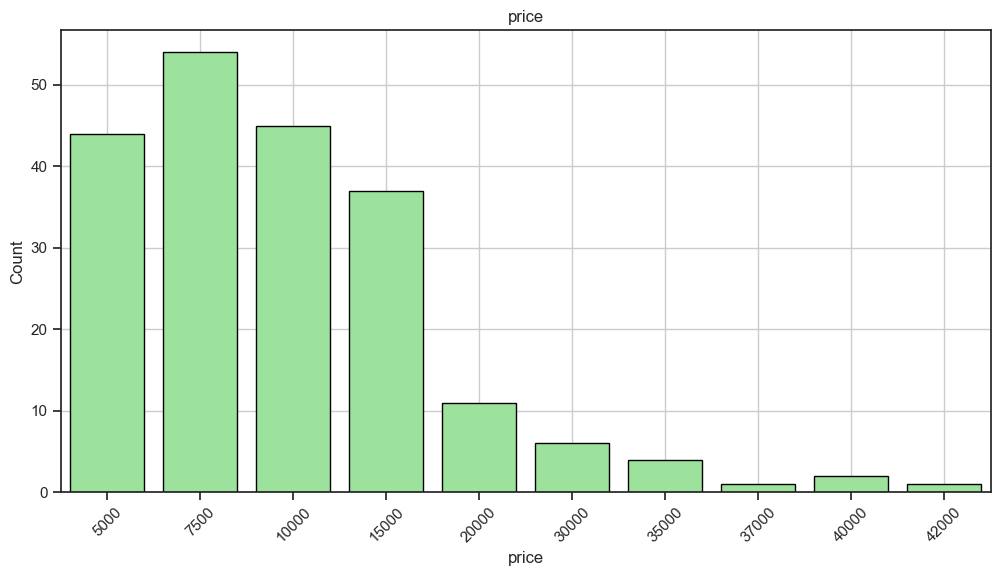

In [133]:
def histogram(df, attribute, ranges):
    counts, _ = np.histogram(df[attribute], bins=ranges)
    sns.set_style("ticks")
    plt.figure(figsize=(12, 6))
    plt.title(attribute)
    sns.barplot(x=ranges[:-1], y=counts, color="lightgreen", edgecolor='black')  
    plt.xlabel(attribute)
    plt.ylabel("Count")
    plt.xticks(rotation=45) 
    plt.grid(True) 
    plt.show()

ranges = [5000,  7500,  10000, 15000, 20000, 30000, 35000, 37000, 40000, 42000, 50000]
histogram(df_filled_with_mean, 'price', ranges)

4. Збудувати графік залежності одного integer/real атрибута від іншого.

Integer - цілі числа. Real - дійсні числа. Будую графік залежності curb_weight (integer) від price (real):

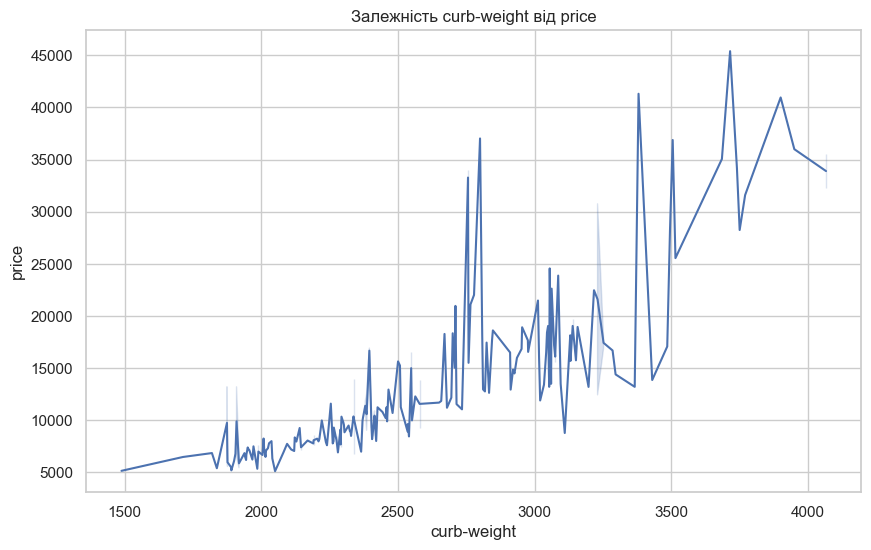

In [134]:
def plot_dependency(df, attribute1, attribute2):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    sns.lineplot(x=df[attribute1], y=df[attribute2], data=df)
    
    plt.title(f"Залежність {attribute1} від {attribute2}")
    plt.xlabel(attribute1)
    plt.ylabel(attribute2)
    plt.show()

plot_dependency(df_filled_with_mean, 'curb-weight', 'price')

5. Підрахувати коефіцієнт Пірсона та Спірмена для двох integer/real атрибутів.

In [17]:
def calculate_correlation(df, attribute1, attribute2):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(df[attribute1], df[attribute2])
    print(f"Коефіцієнт кореляції Пірсона між {attribute1} та {attribute2}: {pearson_corr}")
    print(f"P-значення для кореляції Пірсона: {pearson_p_value}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(df[attribute1], df[attribute2])
    print(f"Коефіцієнт кореляції Спірмена між {attribute1} та {attribute2}: {spearman_corr}")
    print(f"P-значення для кореляції Спірмена: {spearman_p_value}")

if df_filled_with_mean is not None:
    calculate_correlation(df_filled_with_mean, 'curb-weight', 'price')

Коефіцієнт кореляції Пірсона між curb-weight та price: 0.8208247333547292
P-значення для кореляції Пірсона: 2.866332107026708e-51
Коефіцієнт кореляції Спірмена між curb-weight та price: 0.890941464759004
P-значення для кореляції Спірмена: 1.5941916532349746e-71


6. Провести One Hot Encoding категоріального string атрибуту.

In [18]:
def one_hot_encoding(df, columns_to_encode):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df[columns_to_encode])
    encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_feature_names)
    df_encoded = pd.concat([df.drop(columns_to_encode, axis=1), encoded_df], axis=1)
    return df_encoded

if df_filled_with_mean is not None:
    df_encoded = one_hot_encoding(df_filled_with_mean, ['fuel-type'])
    print_table_pd(df_encoded)

Перші 10 рядків DataFrame:
+-----------+-------------------+-------------+------------+--------------+-------------+--------------+-----------------+------------+--------+-------+--------+-------------+-------------+------------------+-------------+-------------+------+--------+-------------------+------------+----------+----------+-------------+--------------------+------------------+---------------+
| symboling | normalized-losses |    make     | aspiration | num-of-doors | body-style  | drive-wheels | engine-location | wheel-base | length | width | height | curb-weight | engine-type | num-of-cylinders | engine-size | fuel-system | bore | stroke | compression_ratio | horsepower | peak-rpm | city-mpg | highway-mpg |       price        | fuel-type_diesel | fuel-type_gas |
+-----------+-------------------+-------------+------------+--------------+-------------+--------------+-----------------+------------+--------+-------+--------+-------------+-------------+------------------+---------

7. Провести візуалізацію багатовимірних даних, використовуючи приклади, наведені у медіумі - https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57.

**Візуалізація даних в одному вимірі (1-D)** : Одним із найшвидших і найефективніших способів візуалізації всіх числових даних та їх розподілу є використання гістограм за допомогою pandas.

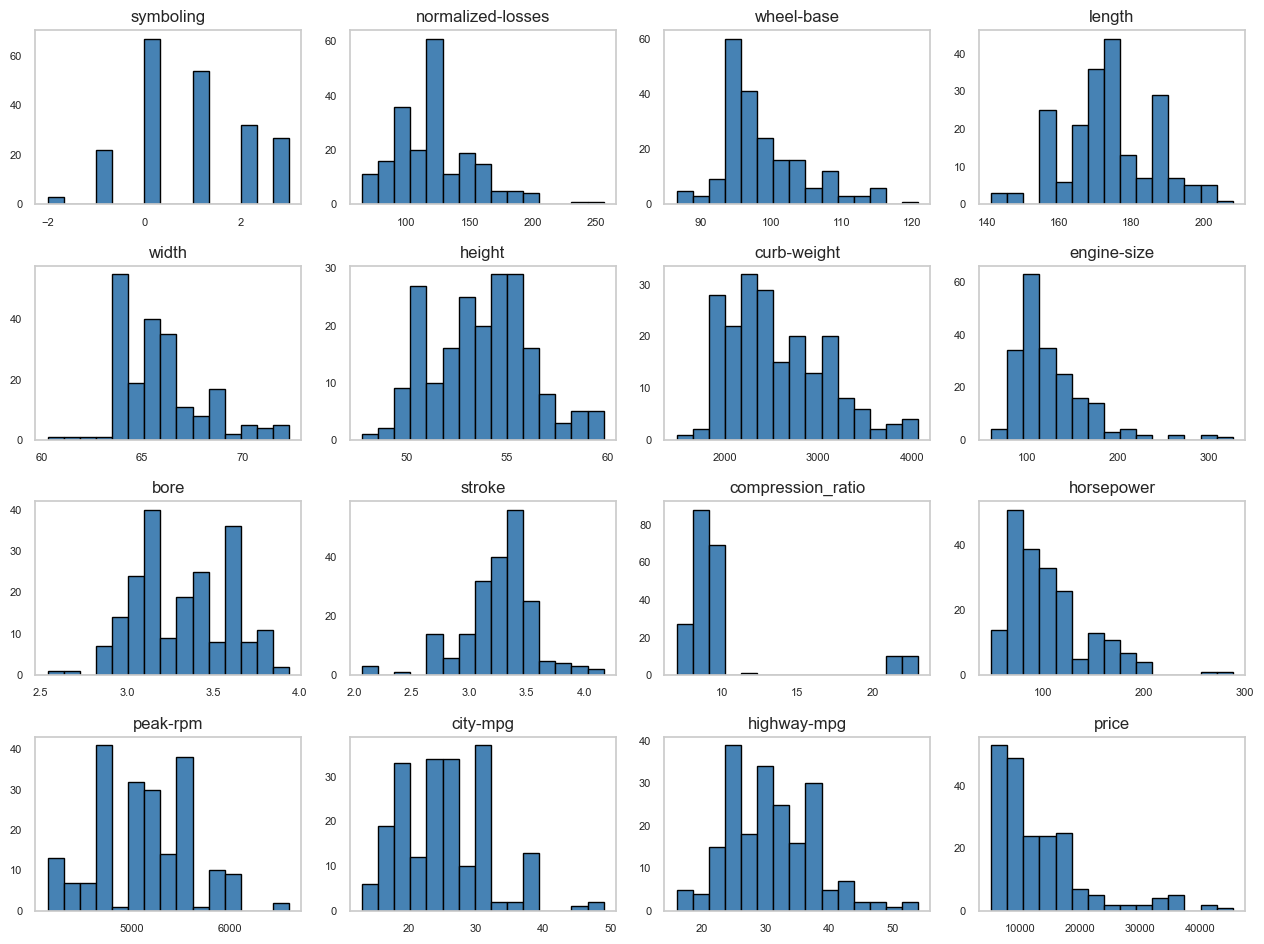

In [19]:
# Візуалізація даних в одному вимірі (1-D)
df_filled_with_mean.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 2, 2))
plt.show()

**Візуалізація даних у двох вимірах (2-D)**: Один із найкращих способів перевірити потенційні зв’язки чи кореляції між різними атрибутами даних – це використати *попарну кореляційну матрицю* та зобразити її як *теплову карту*.

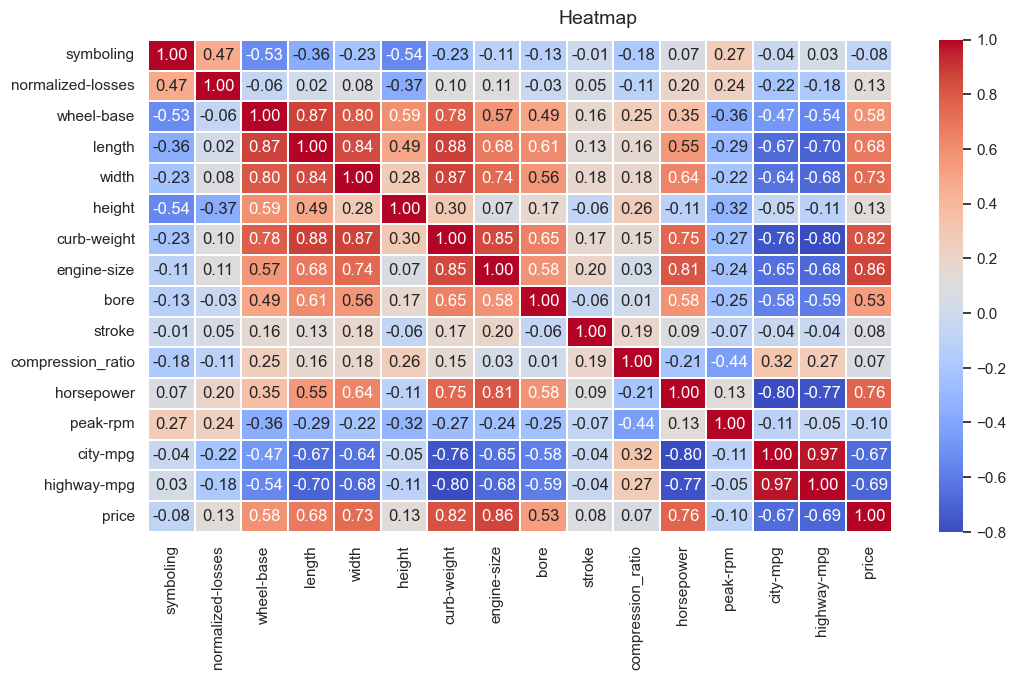

In [23]:
# Візуалізація даних у двох вимірах (2-D)
df_numeric = df_filled_with_mean.select_dtypes(include=['number'])

f, ax = plt.subplots(figsize=(12, 6))
corr = df_numeric.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Heatmap', fontsize=14)

Інший спосіб візуалізувати те саме — використовувати *попарні діаграми розсіювання* серед цікавих атрибутів.

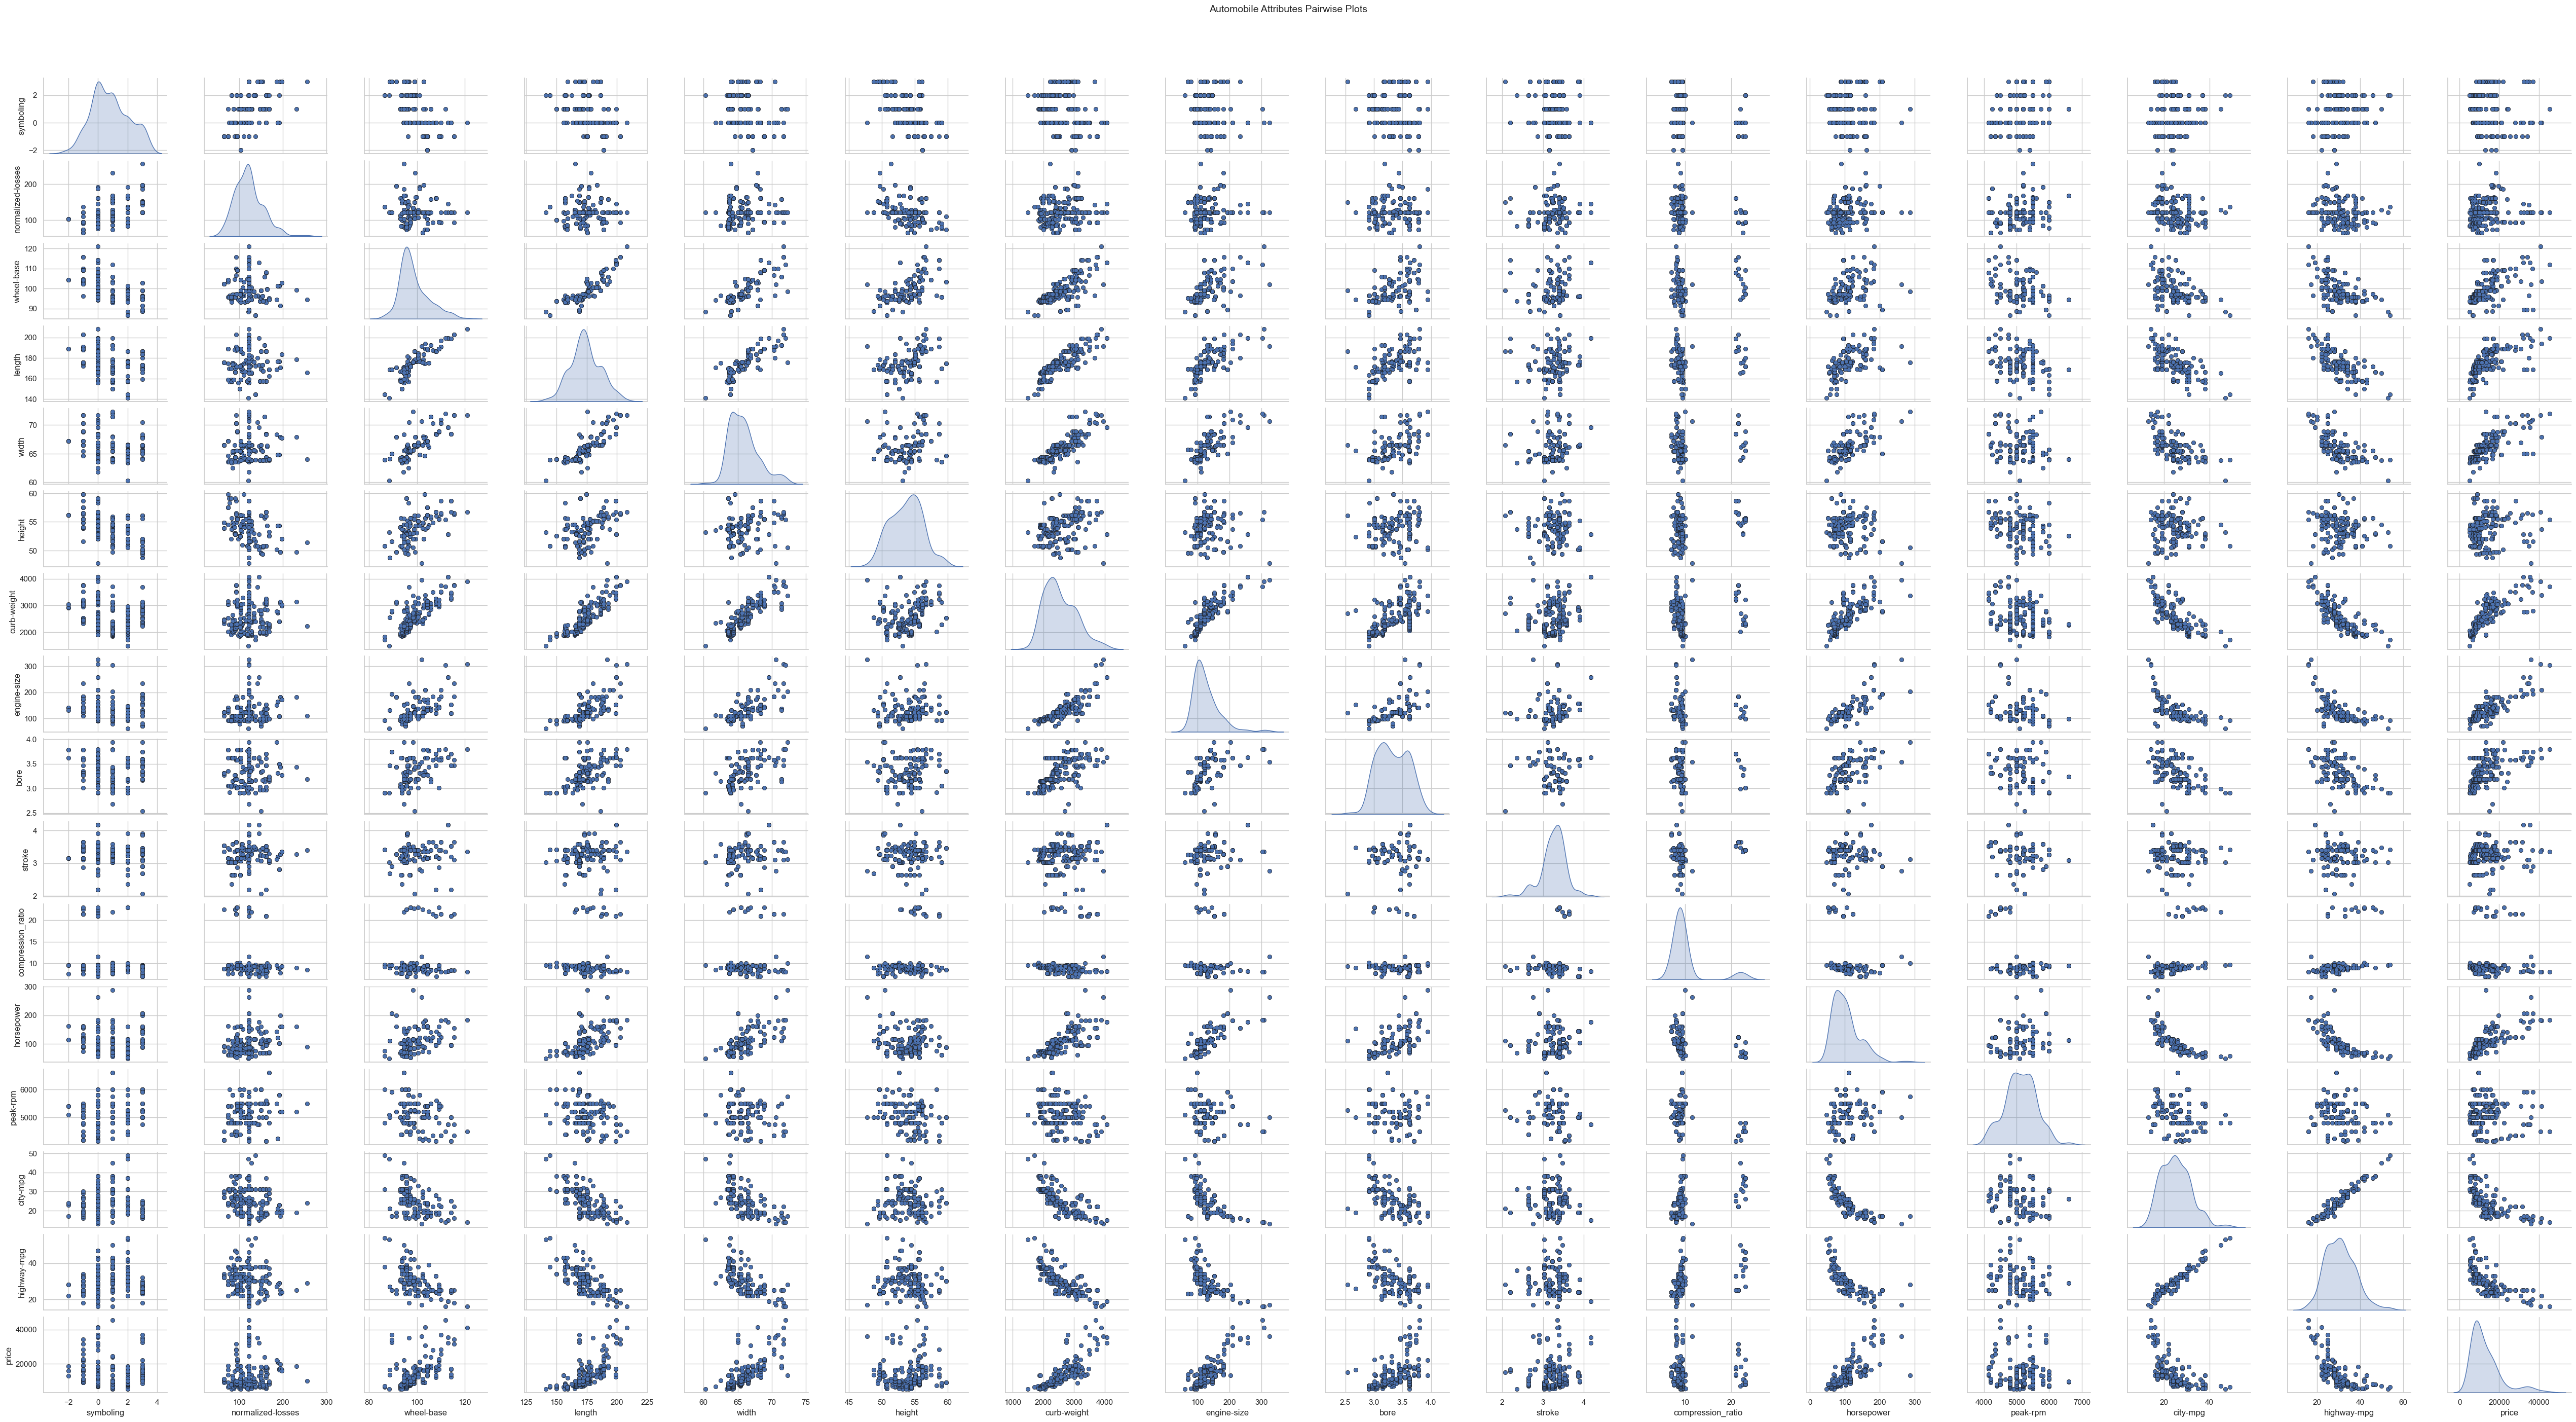

In [29]:
df = df_filled_with_mean.select_dtypes(include=['number'])

pp = sns.pairplot(df, height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(fill=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Automobile Attributes Pairwise Plots', fontsize=14)

**Візуалізація даних у трьох вимірах (3-D)**: Розглядаючи три атрибути або виміри в даних, ми можемо візуалізувати їх, розглянувши попарну діаграму розсіювання та ввівши поняття кольору або відтінку, щоб відокремити значення в категоріальному вимірі.

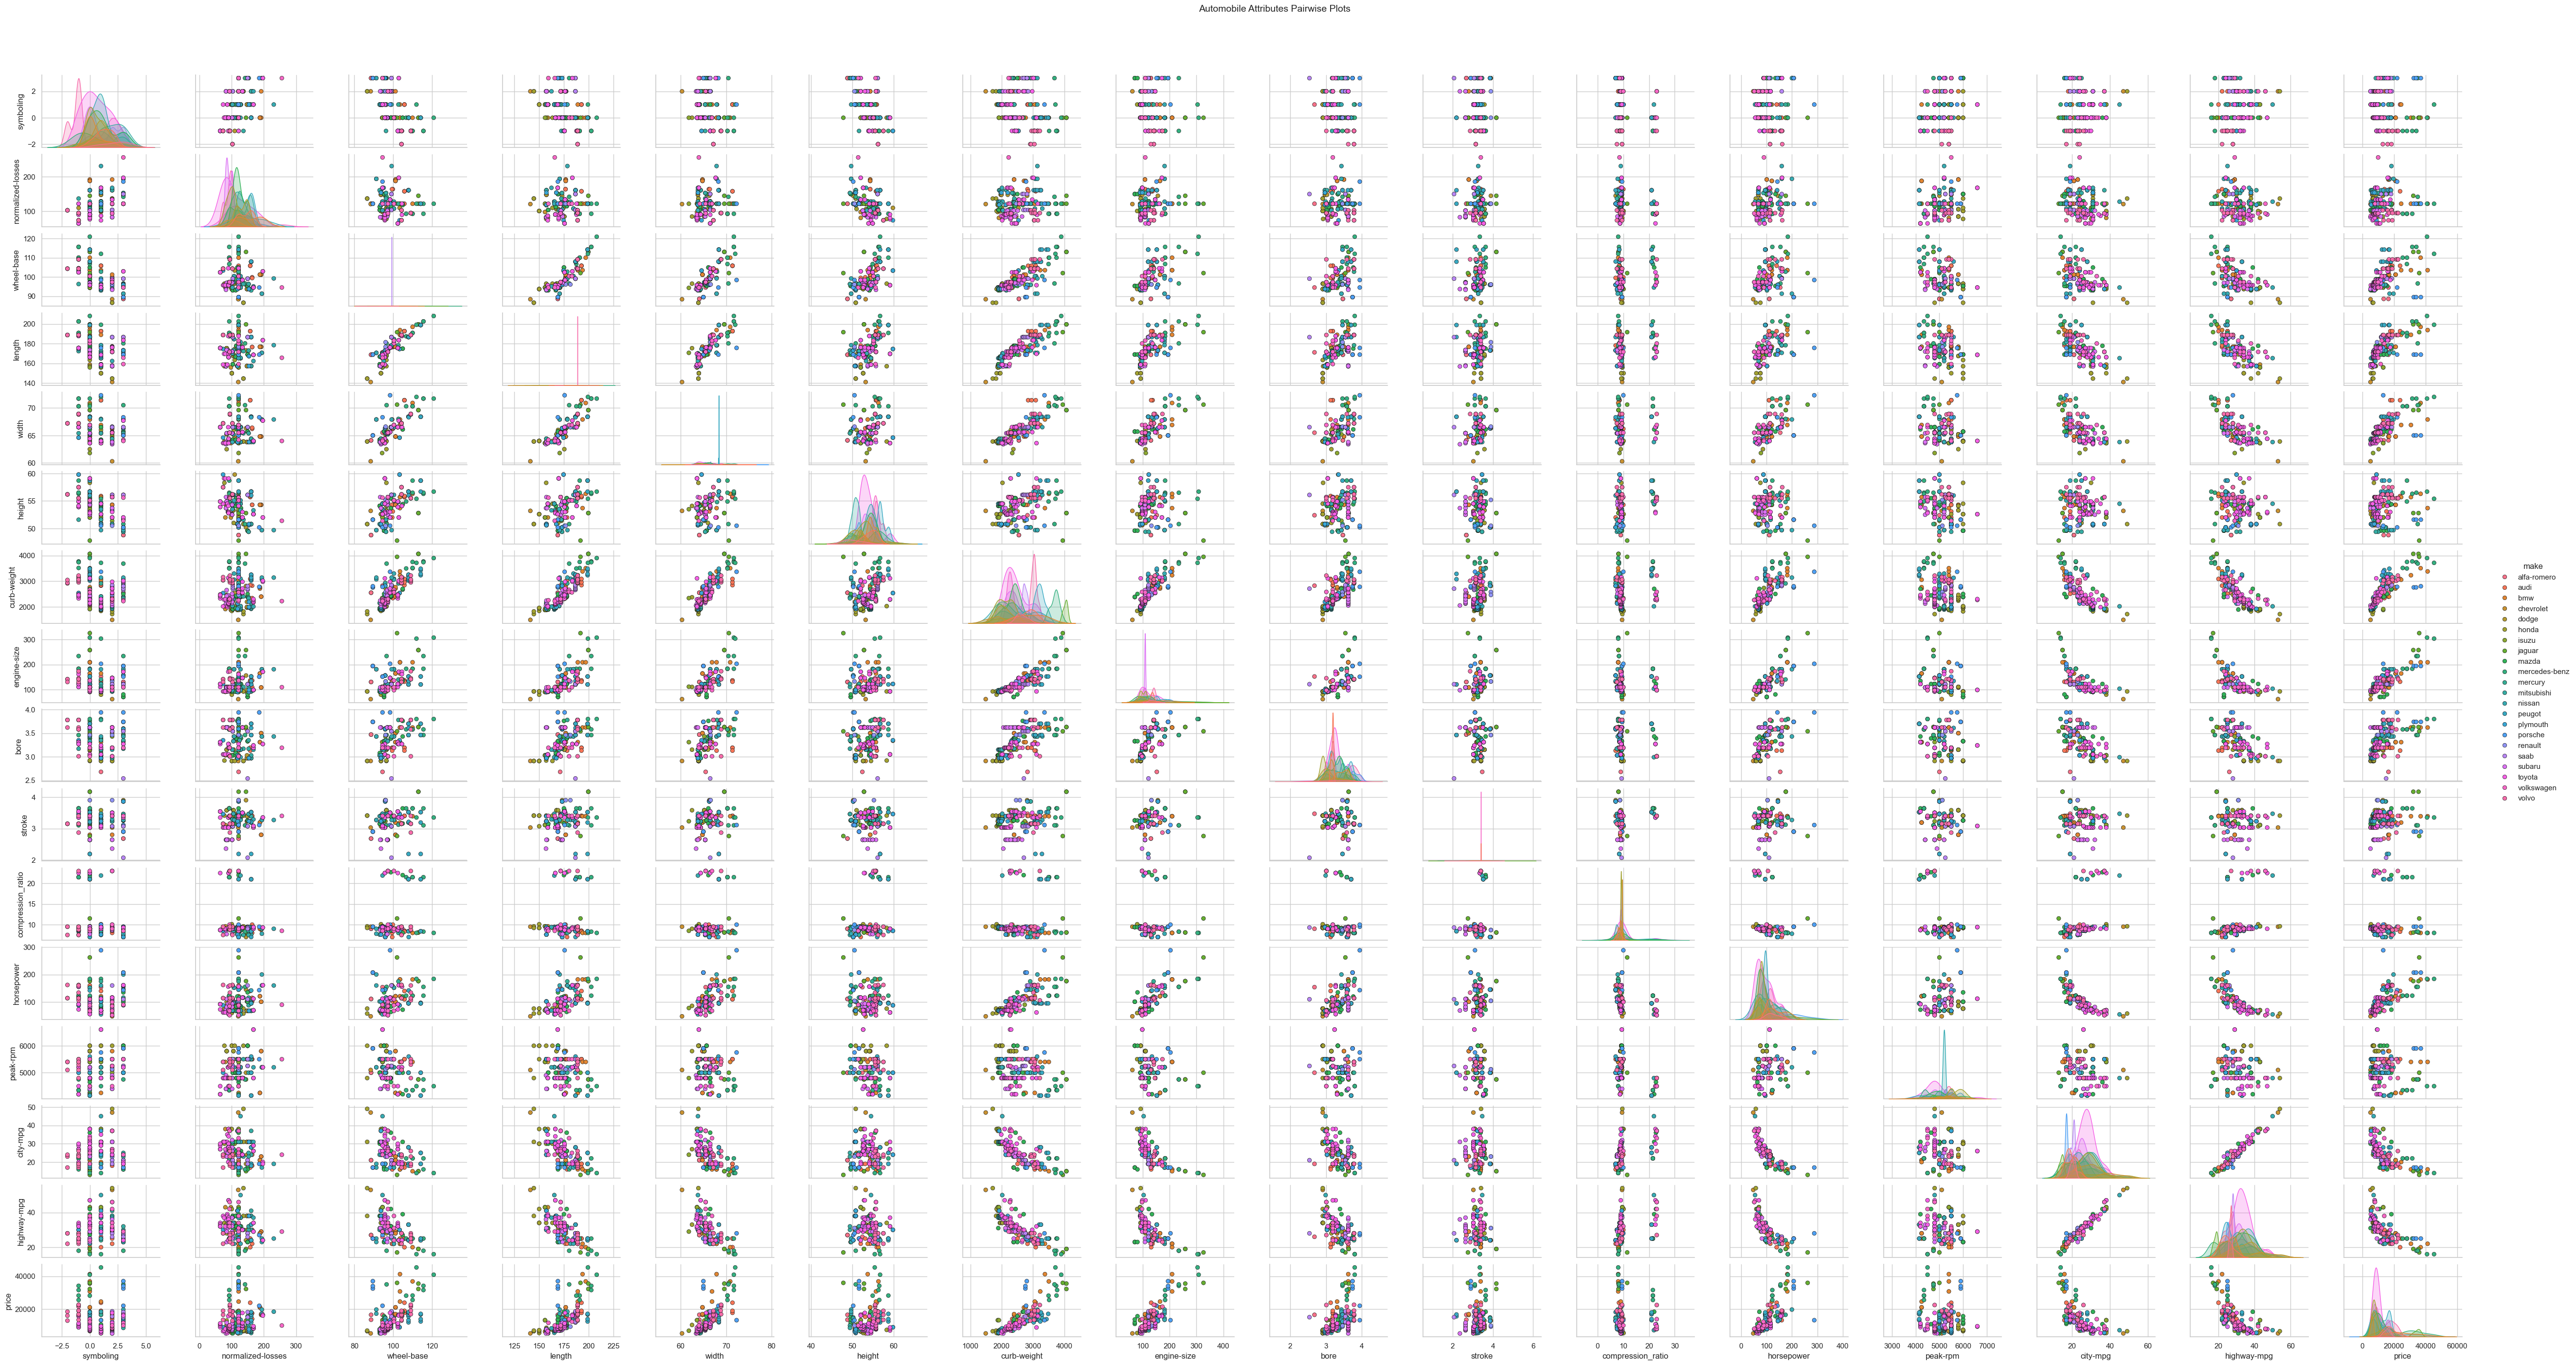

In [38]:
pp = sns.pairplot(df_filled_with_mean, hue='make', height=1.8, aspect=1.8, 
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(fill=True))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Automobile Attributes Pairwise Plots', fontsize=14)

Давайте розглянемо стратегії візуалізації трьох безперервних числових атрибутів . Одним із способів було б мати два виміри, представлені як регулярні довжина ( вісь x ) і ширина ( вісь y ), а також прийняти поняття глибини ( вісь z ) для третього виміру.

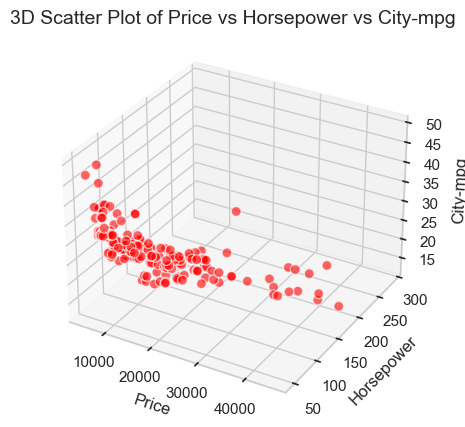

In [128]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

xs = df_filled_with_mean['price']
ys = df_filled_with_mean['horsepower']
zs = df_filled_with_mean['city-mpg']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w', c='red')

ax.set_xlabel('Price', fontsize=12)
ax.set_ylabel('Horsepower', fontsize=12)
ax.set_zlabel('City-mpg', fontsize=12)

ax.set_title('3D Scatter Plot of Price vs Horsepower vs City-mpg', fontsize=14)
plt.show()

**Візуалізація даних у чотирьох вимірах (4-D)**: Одним із способів візуалізації даних у чотирьох вимірах є використання глибини та відтінку як конкретних вимірів даних на звичайній діаграмі, як точкова діаграма.

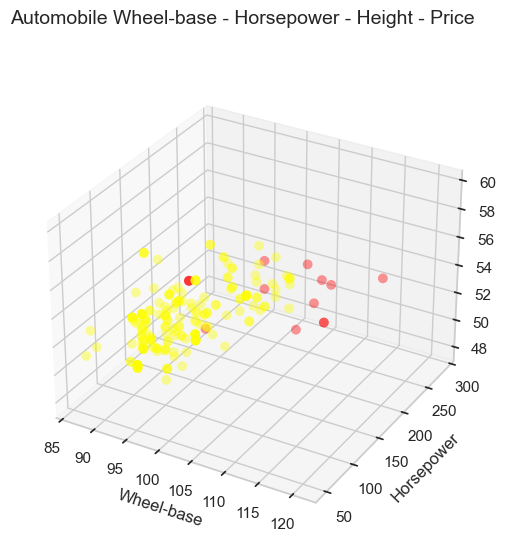

In [122]:
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('Automobile Wheel-base - Horsepower - Height - Price', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df_filled_with_mean['wheel-base'])
ys = list(df_filled_with_mean['horsepower'])
zs = list(df_filled_with_mean['height'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if price > 30000 else 'yellow' for price in df_filled_with_mean['price']]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=50)

ax.set_xlabel('Wheel-base', fontsize=12)
ax.set_ylabel('Horsepower', fontsize=12)
ax.set_zlabel('Height', fontsize=12)
plt.show()

**Візуалізація даних у п’яти вимірах (5-D)**: тривимірна бульбашкова діаграма.

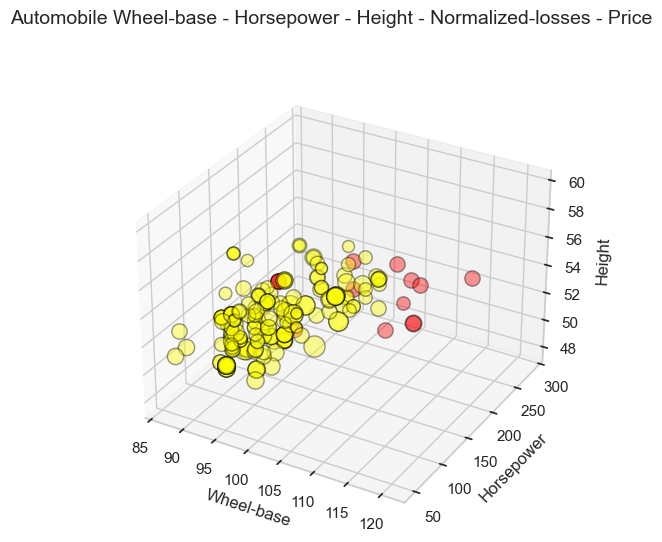

In [118]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('Automobile Wheel-base - Horsepower - Height - Normalized-losses - Price', fontsize=14)

xs = list(df_filled_with_mean['wheel-base'])
ys = list(df_filled_with_mean['horsepower'])
zs = list(df_filled_with_mean['height'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = list(df_filled_with_mean['normalized-losses'])
colors = ['red' if price > 30000 else 'yellow' for price in df_filled_with_mean['price']]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='black', s=size)

ax.set_xlabel('Wheel-base', fontsize=12)
ax.set_ylabel('Horsepower', fontsize=12)
ax.set_zlabel('Height', fontsize=12)
plt.show()

**Візуалізація даних у шести вимірах (6-D)**: Ми будемо використовувати глибину , відтінок , розмір і форму, окрім наших звичайних двох осей, щоб відобразити всі шість вимірів даних.

C:\Users\User\AppData\Local\Temp\ipykernel_24256\3464313266.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='black', s=size, marker=mark)


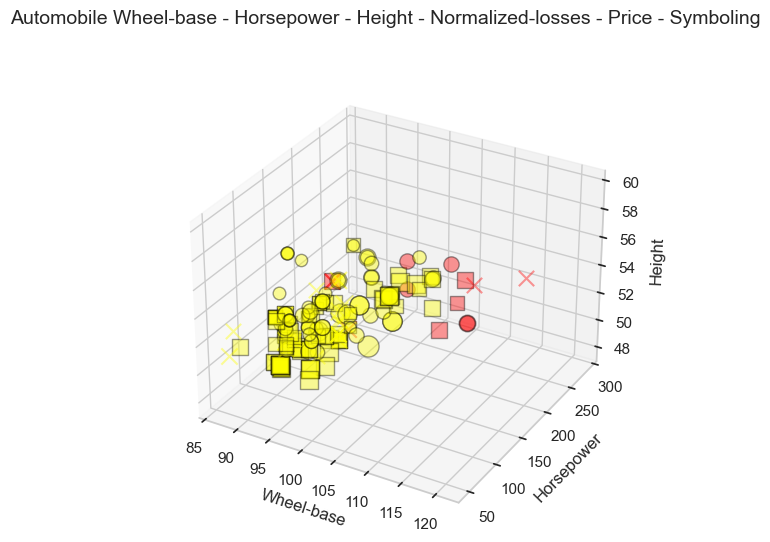

In [131]:
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('Automobile Wheel-base - Horsepower - Height - Normalized-losses - Price - Symboling', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df_filled_with_mean['wheel-base'])
ys = list(df_filled_with_mean['horsepower'])
zs = list(df_filled_with_mean['height'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = list(df_filled_with_mean['normalized-losses'])
colors = ['red' if price > 30000 else 'yellow' for price in df_filled_with_mean['price']]
markers = []
for q in list(df_filled_with_mean['symboling']):
    if q == 0:
        markers.append('o')
    elif q == 1:
        markers.append(',')
    elif q == 2:
        markers.append('x')
    elif q == 3:
        markers.append('s') 

for data, color, size, mark in zip(data_points, colors, ss, markers):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='black', s=size, marker=mark)

ax.set_xlabel('Wheel-base', fontsize=12)
ax.set_ylabel('Horsepower', fontsize=12)
ax.set_zlabel('Height', fontsize=12)
plt.show()